# Librerías

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Carga y preprocesamiento de datos de entrenamiento

In [3]:
train_data = pd.read_csv('train_hora.csv')
train_data['date'] = pd.to_datetime(train_data['date'])
train_data.set_index('date', inplace=True)

scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data['consumption'].values.reshape(-1, 1))

# Función Secuencia

In [4]:
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        targets.append(data[i + seq_length])
    return np.array(sequences), np.array(targets)

In [5]:
sequence_length = 24
X_train, y_train = create_sequences(train_scaled, sequence_length)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

# API Funcional

In [6]:
input_layer = Input(shape=(X_train.shape[1], 1))
x = LSTM(64, return_sequences=False)(input_layer)
output_layer = Dense(1)(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 24, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

# Entrenamiento del modelo

In [7]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_split=0.2,
    verbose=1
)
model.save('modelo1.keras')

Epoch 1/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0300 - mae: 0.1109 - val_loss: 0.0026 - val_mae: 0.0411
Epoch 2/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0022 - mae: 0.0353 - val_loss: 9.9826e-04 - val_mae: 0.0236
Epoch 3/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0011 - mae: 0.0240 - val_loss: 8.5160e-04 - val_mae: 0.0205
Epoch 4/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 8.1085e-04 - mae: 0.0202 - val_loss: 5.9332e-04 - val_mae: 0.0165
Epoch 5/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 6.7781e-04 - mae: 0.0179 - val_loss: 5.3721e-04 - val_mae: 0.0155
Epoch 6/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 6.3917e-04 - mae: 0.0173 - val_loss: 6.0856e-04 - val_mae: 0.0167
Epoch 7/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 6.4058e-04 - mae: 0.0163 - val_loss: 4.5645e-04 - val_mae: 0.0139
Epoch 8/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 6.5337e-04 - mae: 0.0167 - val_loss: 4.3405e-04 - val_mae: 0.0140


# Carga y procesamiento de datos de prueba

In [8]:
test_data = pd.read_csv('test_hora.csv')
test_data['date'] = pd.to_datetime(test_data['date'])
test_data.set_index('date', inplace=True)

test_scaled = scaler.transform(test_data['consumption'].values.reshape(-1, 1))
X_test, y_test = create_sequences(test_scaled, sequence_length)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

predictions = model.predict(X_test)
predictions_rescaled = scaler.inverse_transform(predictions)

273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


# Analisis del conjunto de prueba

In [9]:
total_hours = len(test_data)
total_days = total_hours // 24
print(f'Número total de días en el conjunto de prueba: {total_days}')

day_index = 56
if day_index >= total_days:
    print(f"El day_index ({day_index}) supera el número de días en el conjunto de prueba ({total_days}).")
    day_index = total_days - 2
    print(f"Se ajustó el day_index al último día disponible: {day_index}")

predicted_day = predictions_rescaled[day_index * 24:(day_index + 1) * 24].flatten()
real_day = test_data['consumption'].values[sequence_length + day_index * 24:sequence_length + (day_index + 1) * 24]

start_date = test_data.index[sequence_length + day_index * 24]
print(f"Predicción para el día que comienza el: {start_date.date()}")

Número total de días en el conjunto de prueba: 365
Predicción para el día que comienza el: 2022-02-27


# Evaluación del modelo

In [10]:
y_true = test_data['consumption'].values[sequence_length:]
mse = mean_squared_error(y_true, predictions_rescaled)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, predictions_rescaled)

print(f'RMSE: {rmse}')
print(f'MSE: {mse}')
print(f'MAE: {mae}')

RMSE: 2.68016857751653
MSE: 7.183303603906978
MAE: 1.6403577603354822


# Visualización: Pérdida durante entrenamiento

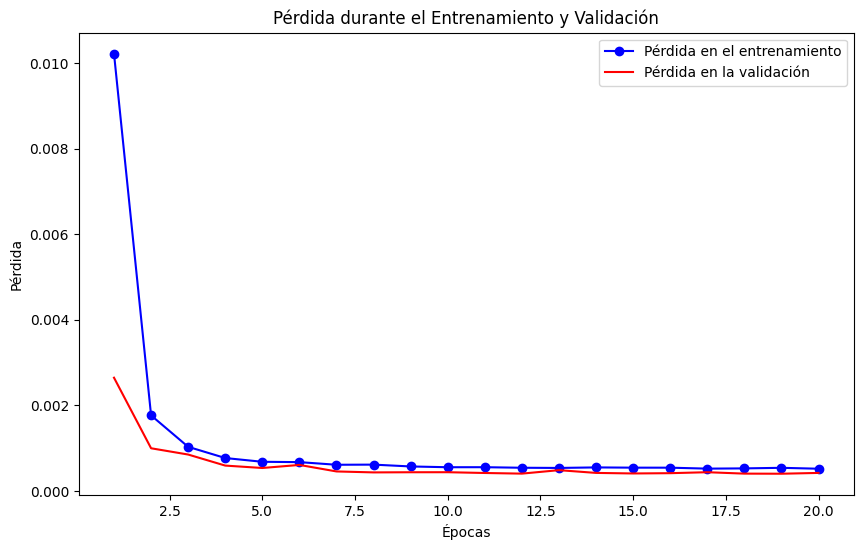

In [11]:
loss_values = history.history['loss']
val_loss_values = history.history['val_loss']
epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_values, 'bo-', label='Pérdida en el entrenamiento')
plt.plot(epochs, val_loss_values, 'r-', label='Pérdida en la validación')
plt.title('Pérdida durante el Entrenamiento y Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

# Predicción vs valores reales

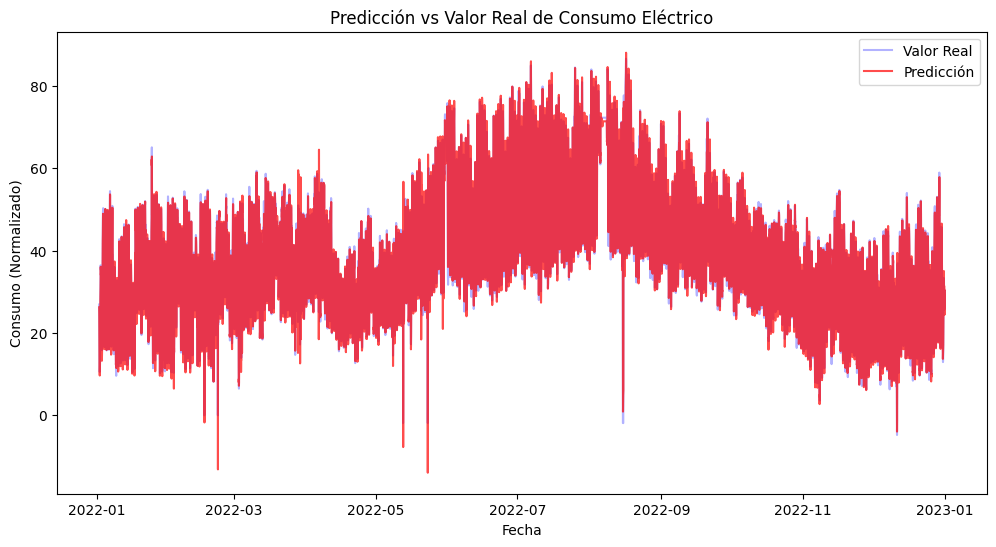

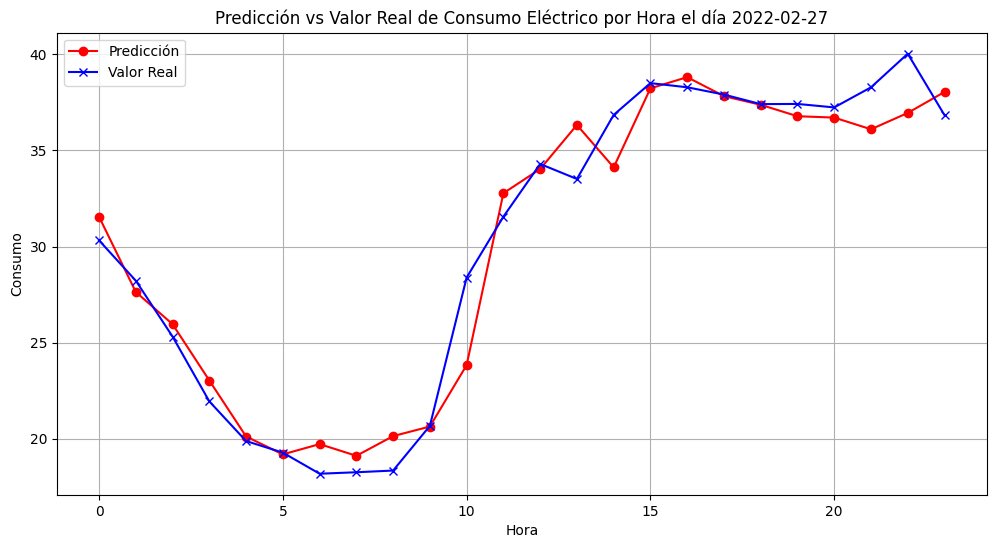

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(test_data.index[sequence_length:], test_data['consumption'][sequence_length:], label='Valor Real', color='blue', alpha=0.3)
plt.plot(test_data.index[sequence_length:], predictions_rescaled, label='Predicción', color='red', alpha=0.7)
plt.title('Predicción vs Valor Real de Consumo Eléctrico')
plt.xlabel('Fecha')
plt.ylabel('Consumo (Normalizado)')
plt.legend()

plt.figure(figsize=(12, 6))
plt.plot(predicted_day, label='Predicción', color='red', marker='o')
plt.plot(real_day, label='Valor Real', color='blue', marker='x')
plt.title(f'Predicción vs Valor Real de Consumo Eléctrico por Hora el día {start_date.date()}')
plt.xlabel('Hora')
plt.ylabel('Consumo')
plt.legend()
plt.grid(True)
plt.show()

# Visualización: Métricas durante el entrenamiento

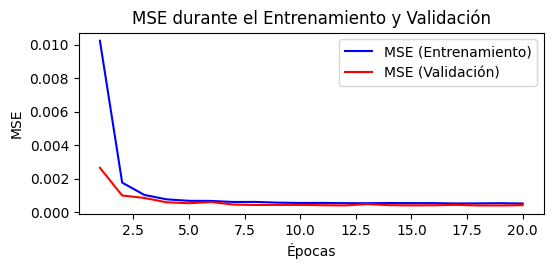

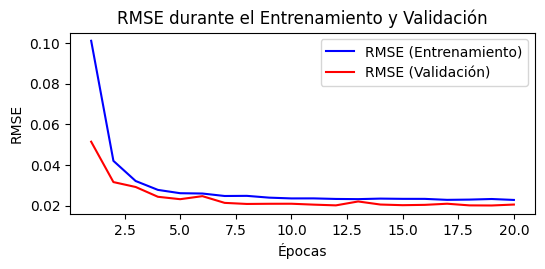

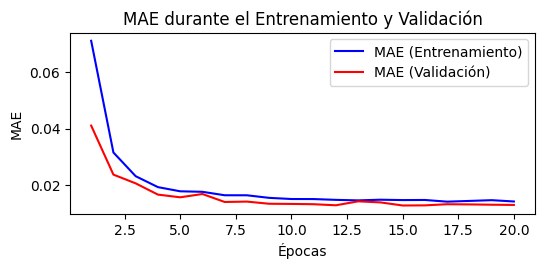

In [23]:
mse_train, mse_val = history.history['loss'], history.history['val_loss']
rmse_train, rmse_val = [np.sqrt(x) for x in mse_train], [np.sqrt(x) for x in mse_val]
mae_train, mae_val = history.history['mae'], history.history.get('val_mae', [])

plt.figure(figsize=(6, 8))
plt.subplot(3, 1, 1)
plt.plot(epochs, mse_train, 'b-', label='MSE (Entrenamiento)')
plt.plot(epochs, mse_val, 'r-', label='MSE (Validación)')
plt.title('MSE durante el Entrenamiento y Validación')
plt.xlabel('Épocas')
plt.ylabel('MSE')
plt.legend()

plt.figure(figsize=(6, 8))
plt.subplot(3, 1, 2)
plt.plot(epochs, rmse_train, 'b-', label='RMSE (Entrenamiento)')
plt.plot(epochs, rmse_val, 'r-', label='RMSE (Validación)')
plt.title('RMSE durante el Entrenamiento y Validación')
plt.xlabel('Épocas')
plt.ylabel('RMSE')
plt.legend()

plt.figure(figsize=(6, 8))
plt.subplot(3, 1, 3)
plt.plot(epochs, mae_train, 'b-', label='MAE (Entrenamiento)')
plt.plot(epochs, mae_val, 'r-', label='MAE (Validación)')
plt.title('MAE durante el Entrenamiento y Validación')
plt.xlabel('Épocas')
plt.ylabel('MAE')
plt.legend()
plt.show()